In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
import math
import sklearn.metrics

In [2]:
# loads csv file as pandas dataframe
df = pd.read_csv (r'Life Expectancy Data.csv')
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [3]:
# preprocessing

# limit the year to 2015 
df = df[df['Year'] == 2015]

# numpy array of target values
df_y = df['Life expectancy '].to_frame()
df_y = df_y.to_numpy()

df = df.drop(['Country', 'Year','Life expectancy '], axis=1)

# convert categorical column to numeric column
df_alter = df['Status']
df_alter.loc[df.Status == 'Developing'] = 0
df_alter.loc[df.Status == 'Developed'] = 1
df['Status'] = df_alter

# created second numpy array after PDP analysis   
df_two = df
df_two = df_two.drop(['Status', 'percentage expenditure','Total expenditure'], axis = 1)
df_two = df_two.to_numpy()

df = df.to_numpy()

#impute missing values
def impute(df):
    avg_vec = []
    for i in range(0, len(df[0])):
        avg = 0
        count = 0
        for j in range(0, len(df)):
            if (math.isnan(df[j][i])):
                count = count + 1
            else:
                avg = avg + df[j][i]
        avg_final = avg / (len(df) - count)
        avg_vec.append(avg_final)
    for i in range(0, len(df[0])):
        for j in range(0, len(df)):
            if (math.isnan(df[j][i])):
                df[j][i] = avg_vec[i]
    return df
                
df = impute(df)
df_two = impute(df_two)
                
# scale the data 
df_x = preprocessing.StandardScaler().fit_transform(df)
df_two = preprocessing.StandardScaler().fit_transform(df_two)
                       

/Users/shelbyku8799/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
'''
Performs k-fold cross validation on the preprocessed data. 
@param  model - type of model
        k (int)
        x (numpy.ndarray) 
        y (numpy.ndarray)
        value (int) - if 1, PDP plots are outputted, if 2, PCA is performed 
Note: the statements that output the PDPs for various features are currently commented out 
because jupyter notebook only allows a limited number of plots to be shown. These statements
were uncommented one at a time when PDP analysis was run.
'''
def k_fold_cross_validation(model, k, x_array, y_array, value):
    score = 0
    length = int(len(y_array))
    size = int(length / k)
    for i in range(0, k):
        test_begin = (size * i)
        test_end = test_begin + size
        x_test = x_array[test_begin:test_end]
        y_test = y_array[test_begin:test_end]
        if i == 0:
            x_train = x_array[test_end:]
            y_train = y_array[test_end:]
        elif i == (k - 1):  
            x_train = x_array[0: test_begin]
            y_train = y_array[0: test_begin]
        else:
            x_train_one = x_array[0: test_begin]
            x_train_two = x_array[test_end:]
            x_train = np.concatenate((x_train_one, x_train_two), axis=0)
            y_train_one = y_array[0: test_begin]
            y_train_two = y_array[test_end:]
            y_train = np.concatenate((y_train_one, y_train_two), axis=0)
        if (value == 1):
            clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1).fit(x_train, y_train.ravel())
            #plot_partial_dependence(clf, x_train, [0, 1])
            #plot_partial_dependence(clf, x_train, [2, 3])
            #plot_partial_dependence(clf, x_train, [4, 5])
            #plot_partial_dependence(clf, x_train, [6, 7])
            #plot_partial_dependence(clf, x_train, [8, 9])
            #plot_partial_dependence(clf, x_train, [10, 11])
            #plot_partial_dependence(clf, x_train, [12, 13])
            #plot_partial_dependence(clf, x_train, [14, 15])
            #plot_partial_dependence(clf, x_train, [16, 17, 18])
        else: 
            if (value == 2):
                pca = PCA(0.95)
                pca = pca.fit(x_train)
                x_train = pca.transform(x_train)
                x_test = pca.transform(x_test)   
            #train Linear Regression model
            model_update = model.fit(x_train, y_train)
            #predict on test set using trained Linear Regression mode
            predictions = model_update.predict(x_test)
            #calculation of MSE
            count = 0
            for i in range(0, len(predictions)):
                count = count + (predictions[i] - y_test[i])**2
            mse = count / len(predictions)
            score = score + mse
    return score / k


In [6]:
model = LinearRegression()

mse_no_pca_no_pdp = []
mse_no_pca_pdp = []
difference_no_pca = []
mse_pca = []
difference_pca_and_pdp = []

#function for when PDP plots were displayed
#k_fold_cross_validation(model, 10, df_x, df_y, 1)

for j in range(2, 20):
    mse_one = k_fold_cross_validation(model, j, df_x, df_y, 0)
    mse_no_pca_no_pdp.append(mse_one)
    mse_two = k_fold_cross_validation(model, j, df_two, df_y, 0)
    mse_no_pca_pdp.append(mse_two)
    difference_no_pca.append(mse_one - mse_two)
    mse_three = k_fold_cross_validation(model, j, df_x, df_y, 2)
    mse_pca.append(mse_three)
    difference_pca_and_pdp.append(mse_two - mse_three)
         
print("No PCA and Before PDP Analysis:")  
print(mse_no_pca_no_pdp)

print("No PCA and After PDP Analysis:")  
print(mse_no_pca_pdp)

#positive value means before PDP yielded a higher mean-squared error
print("Difference between No PCA of Before PDP and After PDP:")
print(difference_no_pca)

print("PCA:")  
print(mse_pca)

#positive value means PCA yielded a higher mean-squared error
print("Diffence between PDP and PCA:")
print(difference_pca_and_pdp)


No PCA and Before PDP Analysis:
[array([29.62834752]), array([29.69259343]), array([19.37868362]), array([19.00740354]), array([19.70086289]), array([18.74057416]), array([18.19025435]), array([19.19443765]), array([17.77877626]), array([18.22457811]), array([18.09056356]), array([18.38921084]), array([18.72692464]), array([18.05531219]), array([17.9080184]), array([18.42972853]), array([18.11839167]), array([18.9874181])]
No PCA and After PDP Analysis:
[array([30.92013709]), array([28.27321188]), array([18.64248746]), array([18.74680052]), array([19.09322026]), array([18.35659777]), array([17.78066299]), array([18.53352992]), array([17.25414828]), array([17.6786144]), array([17.70189279]), array([17.98802329]), array([18.28504475]), array([17.66014881]), array([17.35091123]), array([17.47945111]), array([17.72367214]), array([17.89241987])]
Difference between No PCA of Before PDP and After PDP:
[array([-1.29178958]), array([1.41938155]), array([0.73619616]), array([0.26060301]), array

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from eli5.sklearn import PermutationImportance
from eli5 import show_weights

X_train, X_test, y_train, y_test =  train_test_split(df_x,df_y,test_size = 0.2, random_state= 0)
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)
model = Sequential()

# input layer
model.add(Dense(25, activation="relu", input_shape=(18,)))

# hidden layers
model.add(Dropout(0.2))
model.add(Dense(25, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(25, activation="relu"))

# output layer
model.add(Dense(1, activation="linear"))

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mse"])

X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)

results = model.fit(
    X_train,
    y_train,
    batch_size=5,
    validation_data=(X_test, y_test))

plt.scatter(y_test, preds)
plt.xlabel('True Values')
plt.ylabel('Predictions')

print('MSE :', np.mean(results.history['val_loss']))

bigperm = PermutationImportance(model, scoring='neg_mean_squared_error', random_state=0).fit(X_test, y_test)
for i in range(len(names)):
    print('Feature %d: %s' % (i, names[i]))
show_weights(bigperm)

In [7]:
def get_economic_scores():
    df = pd.read_csv ('efw_cc_updated.csv')
    df.head()
    df.columns
    df = df[df['year'] == 2015]
    df = df.drop(['1a_government_consumption', 'year', 'ISO_code', '1b_transfers', '1c_gov_enterprises',
           '1d_top_marg_tax_rate', '1_size_government', '2a_judicial_independence',
           '2b_impartial_courts', '2c_protection_property_rights',
           '2d_military_interference', '2e_integrity_legal_system',
           '2f_legal_enforcement_contracts', '2g_restrictions_sale_real_property',
           '2h_reliability_police', '2i_business_costs_crime',
           '2j_gender_adjustment', '2_property_rights', '3a_money_growth',
           '3b_std_inflation', '3c_inflation', '3d_freedom_own_foreign_currency',
           '3_sound_money', '4a_tariffs', '4b_regulatory_trade_barriers',
           '4c_black_market', '4d_control_movement_capital_ppl', '4_trade',
           '5a_credit_market_reg', '5b_labor_market_reg', '5c_business_reg',
           '5_regulation', 'rank', 'quartile'], axis=1)
    df = df.rename(columns = {"countries":"Country"})
    return df

In [8]:
def get_life_expectancy():
    df = pd.read_csv ('Life Expectancy Data.csv')
    df.head()
    df.columns
    df = df[df['Year'] == 2015]
    df = df.drop(['Status', 'Year', 'Adult Mortality','infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
           'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
           'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
           ' thinness  1-19 years', ' thinness 5-9 years',
           'Income composition of resources', 'Schooling'], axis=1)
    return df

In [9]:
'''
Renders a simple (x,y) plot. 
@param x (numpy.ndarray) - average number of rooms 
       y (numpy.ndarray) - median price of house 
'''
def simple_plot(x,y):
    plt.scatter(x,y)
    plt.title('Countries Around the World')
    plt.xlabel('Economic Freedom Score (1-10)')
    plt.ylabel('Life Expectancy (years)')
    plt.show()

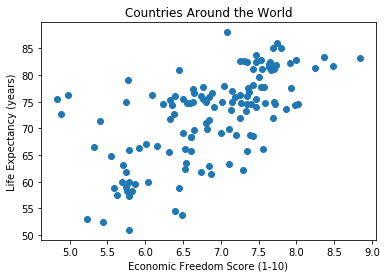

In [10]:
#TODO
# Run the functions here. 
life_expectancy =  get_life_expectancy()
economic_scores = get_economic_scores()
    
df3 = pd.merge(life_expectancy, economic_scores, how='inner', on = 'Country')

# print(df3[["ECONOMIC FREEDOM"]])

life_expect_list = df3[["Life expectancy "]]
econ_score_list = df3[["ECONOMIC FREEDOM"]]

simple_plot(econ_score_list, life_expect_list)

In [11]:
def plot_actual_vs_pred(test_x, test_y, pred_y):
    predicted = plt.scatter(test_x, test_y, color='blue')
    actual = plt.scatter(test_x, pred_y, color='red')
    plt.title('Economic Freedom Score vs. Actual Life Expectancy and Predicted Life Expectancy')
    plt.xlabel('Economic Freedom Score (1-10)')
    plt.ylabel('Life Expectancy (years)')
    plt.legend((predicted, actual), ('Actual', 'Predicted'), scatterpoints = 1, loc = 'upper left')
    plt.show()
    return

[35.008552]
[[5.5303571]]


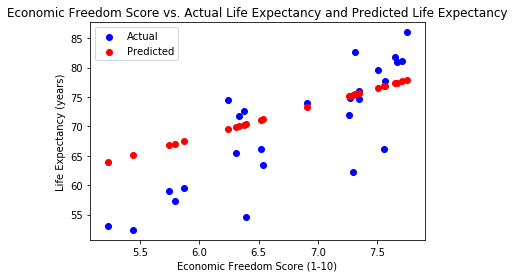

r^2 score:  0.4503196212786459


In [12]:
X_train, X_test, y_train, y_test = train_test_split(econ_score_list, life_expect_list, 
                                                    test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)
y_pred = regressor.predict(X_test)
plot_actual_vs_pred(X_test, y_test, y_pred)
r2_score = sklearn.metrics.r2_score(y_test, y_pred)
print("r^2 score: ", r2_score)